In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns


# The name of our fintech: (on a des points bonus pour le meilleur nom)

In [2]:
training_data = pd.read_csv("PastLoans.csv")
prediction_data = pd.read_csv("NewApplications_Lender2_Round1.csv")

In [3]:
training_data.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,M,unemployed,0,0,0.749267,0.422656,0.738735,0
1,M,employed,1,26108,0.697428,0.596361,0.733947,0
2,M,employed,1,11810,0.000000,0.652496,0.000000,0
3,M,unemployed,1,0,0.000000,0.000000,0.000000,0
4,F,retired,1,6310,0.000000,0.041123,0.203202,0


In [4]:
training_data.default.value_counts()

default
0    90053
1     9947
Name: count, dtype: int64

In [12]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sex         100000 non-null  object 
 1   employment  100000 non-null  object 
 2   married     100000 non-null  int64  
 3   income      100000 non-null  int64  
 4   digital1    100000 non-null  float64
 5   digital2    100000 non-null  float64
 6   digital3    100000 non-null  float64
 7   default     100000 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 6.1+ MB


In [13]:
training_data.describe()

,married,income,digital1,digital2,digital3,default
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.60822,18646.253910,0.417739,0.415741,0.414914,0.099470
std,0.48815,48178.198971,0.325269,0.325093,0.325064,0.299294
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,5385.000000,0.064623,0.062594,0.060467,0.000000
50%,1.00000,9370.000000,0.448209,0.444645,0.440936,0.000000
75%,1.00000,17474.250000,0.696019,0.694762,0.692441,0.000000
max,1.00000,1000000.000000,0.999975,0.999986,0.999965,1.000000


# Model to predict default

In [5]:
X = training_data.drop(['default', 'digital1', 'digital3'], axis=1)
y = training_data['default']

X = pd.get_dummies(X, columns=['sex', 'employment'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### optuna optimising, maximising PR-AUC

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [17]:
from sklearn.metrics import precision_recall_curve, auc
import xgboost as xgb
import optuna


# Define the objective function for Optuna
def objective(trial):
  param = {
      'objective': 'binary:logistic',
      'eval_metric': 'aucpr',
      'booster': 'gbtree',
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
      'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
      'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0)
  }

  model = xgb.XGBClassifier(**param, use_label_encoder=False)
  model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

  y_pred_proba = model.predict_proba(X_test)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  pr_auc = auc(recall, precision)
  return pr_auc

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)


[I 2024-10-23 16:45:57,734] A new study created in memory with name: no-name-0fdf8ca4-1296-4ce6-b7df-3a1e850cfb5c
/var/folders/0v/fw0f69gx3sl0p61_gl_fnyj80000gn/T/ipykernel_13556/2373475020.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/0v/fw0f69gx3sl0p61_gl_fnyj80000gn/T/ipykernel_13556/2373475020.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/var/folders/0v/fw0f69gx3sl0p61_gl_fnyj80000gn/T/ipykernel_13556/2373475020.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

Best hyperparameters:  {'lambda': 0.05375036953128944, 'alpha': 0.21259624181932602, 'colsample_bytree': 0.815014193885844, 'subsample': 0.5577844236119344, 'learning_rate': 0.23035347312749993, 'n_estimators': 158, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 6.556924414787855}


Final PR AUC:  0.2165101810991389


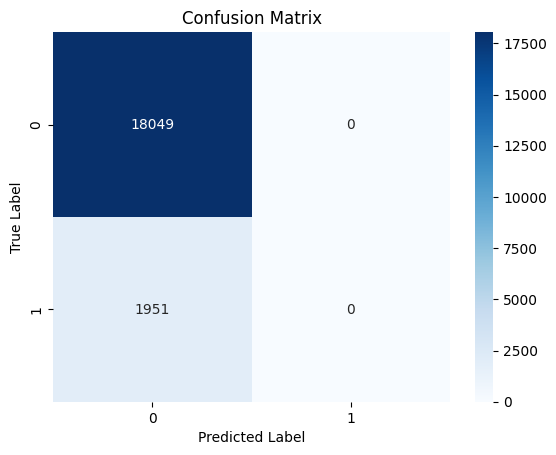

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
final_pr_auc = auc(recall, precision)
print("Final PR AUC: ", final_pr_auc)

threshold = 0.5
y_pred_binary = (y_pred_proba >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

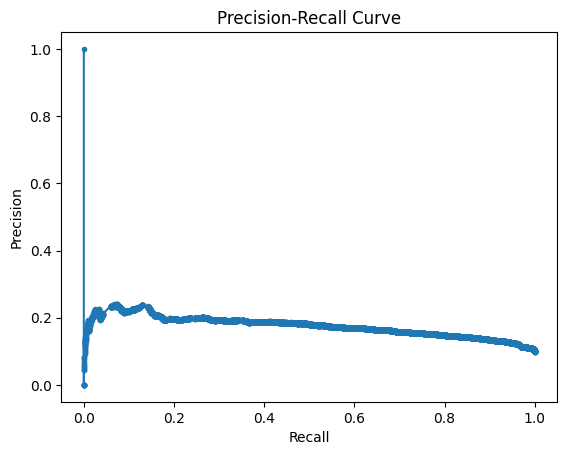

Selected threshold for desired recall: 0.49686784632918646


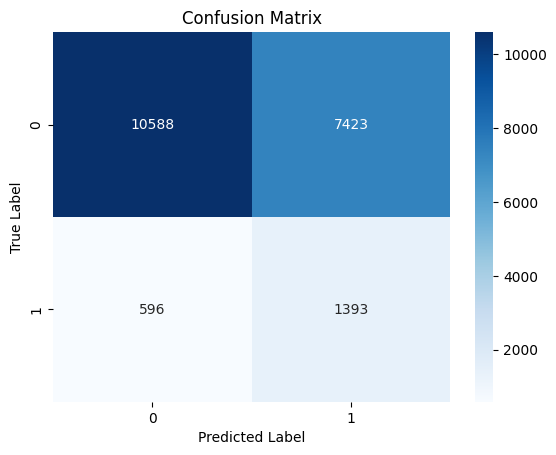

              precision    recall  f1-score   support

           0       0.95      0.59      0.73     18011
           1       0.16      0.70      0.26      1989

    accuracy                           0.60     20000
   macro avg       0.55      0.64      0.49     20000
weighted avg       0.87      0.60      0.68     20000



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Choose a threshold that gives a higher recall
# For example, choose a threshold that gives at least 0.7 recall
desired_recall = 0.7
threshold_index = np.where(recall >= desired_recall)[0][-1]
selected_threshold = thresholds[threshold_index]

print(f"Selected threshold for desired recall: {selected_threshold}")

# Convert probabilities to binary predictions using the selected threshold
y_pred_binary = (y_pred_proba >= selected_threshold).astype(int)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_binary))

In [31]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [33]:
# Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step - accuracy: 0.8721 - loss: 26.6148 - val_accuracy: 0.9032 - val_loss: 10.3455
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.8652 - loss: 10.7130 - val_accuracy: 0.9032 - val_loss: 20.2697
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - accuracy: 0.8543 - loss: 6.0445 - val_accuracy: 0.9031 - val_loss: 3.2666
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.8586 - loss: 9.6365 - val_accuracy: 0.8774 - val_loss: 0.5491
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.8538 - loss: 4.0029 - val_accuracy: 0.9018 - val_loss: 0.9944
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - accuracy: 0.8581 - loss: 1.4699 - val_accuracy: 0.9025 - val_loss: 0.3377
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.8968 - loss: 0.3451 - val_accuracy: 0.9029 - val_loss: 0.3101
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.8994 - loss: 

In [34]:
# Logistic Regression Evaluation
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

# Neural Network Evaluation
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     18049
           1       0.00      0.00      0.00      1951

    accuracy                           0.90     20000
   macro avg       0.45      0.50      0.47     20000
weighted avg       0.81      0.90      0.86     20000

XGBoost:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     18049
           1       1.00      0.00      0.00      1951

    accuracy                           0.90     20000
   macro avg       0.95      0.50      0.48     20000
weighted avg       0.91      0.90      0.86     20000

194/625 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
Neural Network:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     18049
           1       0.00      0.00      0.00      1951

    accuracy                           0.90     20000
   macro avg       0.45      0.50      0.47     20000
weighted avg       0.81      0.90      0.86     20000



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predicting default of clients

In [35]:
prediction_data.head()

,id,sex,employment,married,income,digital2
0,1,M,employed,0,29758,0.000000
1,2,F,retired,1,6140,0.000000
2,3,F,employed,1,27186,0.008139
3,4,M,employed,1,8429,0.624570
4,5,M,retired,1,2820,0.097230


In [43]:
prediction_data_transformed = pd.get_dummies(prediction_data, columns=['sex', 'employment'], drop_first=True)
prediction_data_transformed = prediction_data_transformed.drop('id', axis=1)

In [44]:
prediction_data_transformed

,married,income,digital2,sex_M,employment_retired,employment_student,employment_unemployed
0,0,29758,0.000000,True,False,False,False
1,1,6140,0.000000,False,True,False,False
2,1,27186,0.008139,False,False,False,False
3,1,8429,0.624570,True,False,False,False
4,1,2820,0.097230,True,True,False,False
...,...,...,...,...,...,...,...
99995,1,9027,0.070968,True,True,False,False
99996,0,6229,0.635176,True,False,True,False
99997,1,6471,0.748987,True,False,False,False
99998,0,32654,0.000000,True,False,False,True


In [45]:
y_prob_log_reg = log_reg.predict_proba(prediction_data_transformed)[:, 1]
y_prob_xgb = xgb_model.predict_proba(prediction_data_transformed)[:, 1]
y_prob_nn = nn_model.predict(prediction_data_transformed).flatten()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step


# Calculate interest rate

$ r_i = \frac{PD_i}{1 - PD_i} $

In [21]:
def calculate_interest_rate(probabilities):
    return probabilities / (1 - probabilities)

In [47]:
def calculate_interest_rate(probabilities):
    return probabilities / (1 - probabilities)

interest_rates_log_reg = calculate_interest_rate(y_prob_log_reg)
interest_rates_xgb = calculate_interest_rate(y_prob_xgb)
interest_rates_nn = calculate_interest_rate(y_prob_nn)

In [48]:
margin = 0.02  # Example margin of 2%
final_interest_rates_log_reg = interest_rates_log_reg + margin
final_interest_rates_xgb = interest_rates_xgb + margin
final_interest_rates_nn = interest_rates_nn + margin

In [22]:
new_model_interest_rates = calculate_interest_rate(y_pred_proba)


In [23]:
results = pd.read_csv("Round1_Diagnostic_32.csv")
results.head()

,id,own,competing1,competing2,borrowertype,accepted,default,profit
0,1,0.013320,0.027688,0.042200,3,1,0,133.19841
1,2,0.150047,0.967304,0.206900,1,1,1,-10000.00000
2,3,0.178069,0.028157,0.031022,3,0,0,NaN
3,4,0.132574,0.827000,0.099100,3,0,0,NaN
4,5,0.284470,1.000000,0.368400,1,1,0,2844.69750


In [27]:
y_pred_proba.mean()

0.4292160160692218

In [26]:
new_model_interest_rates.mean()

0.9343963662417233